# COMP20008 2021S1 workshop week 10

## Chi Squared Feature Selection
The following code implements the example in Slide 19 of the Experimental design lecture

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import chi2_contingency

In [2]:
data = pd.DataFrame(np.array([[1, 1, 1],[1, 0, 1],[0, 1, 0],[0, 0, 0]]), 
                    columns=['a1', 'a2', 'c'])
data

,a1,a2,c
0,1,1,1
1,1,0,1
2,0,1,0
3,0,0,0


In [3]:
X = data[['a1', 'a2']]
y = data['c']

# create a contingency table to calculate chi2 for y and A1
contingency_table = pd.crosstab(y, X['a1'])
contingency_table

a1,0,1
c,,
0,2,0
1,0,2


In [4]:
chi2_val, p, dof, expected = chi2_contingency(contingency_table.values, correction=False)

## Hypothesis Testing
- Hypothesis testing is one way of statistically testing the significance of a feature or value.
- In this example, we are calculating the $\chi^2$ values of our feature `"a1"` w.r.t (with respect to) our class label `"c"`.

To create a hypothesis test, we propose the following:
1. NULL Hypothesis: The feature is is not significant (or in other words, the feature is useless and doesn't provide anything usefl)
2. Alternative Hypothesis: The feature is significant and provides useful insight statistically.

To find out what hypothesis holds, we need to compute the `p-value`.

#### So what's the p-value?
- The `p-value` is the *probability* of obtaining results that are *at least as extreme* (i.e outliers) as the results observed.
- These observations are under the assumption that the NULL hypothesis (the feature is useless) is correct.
- However, if the `p-value` is small, then it means that our *observed extreme results* are very unlikely under the NULL hypothesis. 
- Therefore, given some small threshold $\alpha$ (usually 0.05), we **reject the NULL hypothesis** iff (if and only if) `p-value` < $\alpha$.

#### In other words...
1. Write down your NULL and Alternative hypothesis.
2. Compute the $\chi^2$ value and corresponding `p-value`.
3. If `p-value` is less than $\alpha$ = 0.05, then you **reject the NULL hypothesis**.
    1. If you reject the NULL, then you can word it as such:  
        "Since our XXX is significantly larger than the expected XXX value, we reject the null hypothesis and conclude that there is evidence that our feature XXX is XXX.
    2. If you fail to reject the NULL:
        "Since our XXX is smaller than the expected XXX value, we **fail to reject the null hypothesis**."

In [5]:
print(f"{chi2_val} with p-value {p}")

4.0 with p-value 0.04550026389635857


## Exercise Question (in your own time)
- Adapt the example above to calculate the $\chi^2$ value for feature `"a2"`.  
- Ensure that the results agree with your answer to Question 1.

In [6]:
data = pd.DataFrame(np.array([[1, 1, 1],[1, 0, 1],[0, 1, 0],[0, 0, 0]]), 
                    columns=['a1', 'a2', 'c'])
data

,a1,a2,c
0,1,1,1
1,1,0,1
2,0,1,0
3,0,0,0


## $k$-Fold Cross Validation (CV)
- As mentioned previously, the common 80/20 train/test split is unreliable due to some factors such as a fixed random seed.
- A much better alternative is $k$-Fold CV.

#### How does it work?
- The approach randomly divides the dataset into $k$ approximately equal "folds".
- Each of these "folds" is then used as an evaluation set in $k$ different interations. 
- That is, each iteration of $k$-fold CV will have different "folds" taking turns at being the evaluation set.
- For example, if we had $k=3$, then the first iteration involves having "folds" 1 & 2 for train, with 3 for evaluation.
- In the next iteration, we might have "folds" 1 & 3 for train, with 2 for evaluation.
- (and so on...)

In [7]:
# read in world org and set index to country code
df_world = pd.read_csv('world_org.csv')
df_world.set_index('Country Code')

# read in life and set index to country code
df_life = pd.read_csv('life.csv')
df_life.set_index('Country Code')

# merge the two dataframes together on country code
df = df_world.merge(df_life)

# delete the first two to save memory
del df_world, df_life

In [8]:
from sklearn.model_selection import KFold

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score

In [9]:
X = df.iloc[:, 5:-1]
y = df['Life expectancy at birth (years)']

# set k value for k-fold CV
k = 10

kf_CV = KFold(n_splits=k, shuffle=True, random_state=42)
results = []

for train_idx, test_idx in kf_CV.split(X):
    X_train, X_test = X.loc[train_idx], X.loc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Preprocessing
    # 1. Standardise the data
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)    
    
    # 2. Impute missing values using mean
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    
    # Training
    knn = KNN(n_neighbors=5)
    knn.fit(X_train, y_train)    
    
    # Predictions
    y_pred = knn.predict(X_test)
    results.append(accuracy_score(y_test, y_pred))

In [10]:
print(f"Average Accuracy: {np.mean(results)}")

Average Accuracy: 0.7254385964912282


## Question
- What happens when we have diferent values of $k$ or change the random seed?
- What might be an optimal value of $k$ for this dataset?
- Is a large $k$ always good?

## Principal Component Analysis (PCA)
- PCA is used to transform high-dimensional data (i.e many features) into a lower-dimensional representation (i.e fewer features).
- It is especially useful for visualisation and to improve computational efficiency by removing outliers or noisy data.
- In layman's terms, PCA aims to discover a new coordinate system such that most of the **variance** is concentrated along the coordinates from most to least.
- PCA is very useful and widely used in industry.

#### How does this work (EASY)?
- PCA discards dimensions (i.e features) that tell us very little about the data.
- Once the features are discarded, we will be left with a smaller coordinate system (usually 2D axes).
- The smaller coordinate system will *encapsulate* most of the **variance** in the dataset.
- In other words, dimensions that do not have much variation in the data or holds little information will be discarded.

#### How does this work (EXTENSION)?
- PCA is a constraint optimisation problem using Langrange multipliers.
    - Problem: Find a $p_1$ that maximises $p_1'\sum_{X}p_1$ where $||p_1||=p_1'p_1=1$ must be satisfied.
    - Constraint: $L = p_1'p_1\sum_{X} - \lambda_1\times(p_1'p_1 - 1)$
- By solving for 0 (given the langrange equations), you can perform eigenvalue decomposition, where $\lambda_1$ yields eigenvalues and your vector $p_1$ is an eigenvector.
- The end result is an orthnonormal basis where axes are aligned to capture the maximum **variance** (or variation) in the dataset.

In [11]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [12]:
X = df.iloc[:, 5:-1]
y = df['Life expectancy at birth (years)']

# set k value for k-fold CV
k = 10

kf_CV = KFold(n_splits=k, shuffle=True, random_state=42)
results = []

for train_idx, test_idx in kf_CV.split(X):
    X_train, X_test = X.loc[train_idx], X.loc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Preprocessing
    # 1. Standardise the data
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)    
    
    # 2. Impute missing values using mean
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    
    # 3. Perform PCA on the dataset
    pca = PCA(n_components=5)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    
    # Training
    knn = KNN(n_neighbors=5)
    knn.fit(X_train, y_train)    
    
    # Predictions
    y_pred = knn.predict(X_test)
    results.append(accuracy_score(y_test, y_pred))

In [13]:
print(f"Average Accuracy: {np.mean(results)}")

Average Accuracy: 0.7271929824561403


#### Some pointers for PCA
- When we visualise data using PCA, it's best to keep it to 2 or 3 components for best practices (2D and 3D respectively).
- However, when we build a model, we can try taking a look at `pca.explained_variance_ratio_` to see how much of the variance is being explained by the first X components.

In [14]:
pca.explained_variance_ratio_

array([0.19585359, 0.10985296, 0.0686636 , 0.04404539, 0.03371476])

# Visualisation using PCA

- Here's an example below of applying PCA on the iris dataset.


In [15]:
df_iris = pd.read_csv('iris.csv')
X = df_iris[["SepalLength", "SepalWidth", "PetalLength", "PetalWidth"]]

In [16]:
# for 2D visualisations, we have 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
pca.explained_variance_ratio_

array([0.92461621, 0.05301557])

In [17]:
sum(pca.explained_variance_ratio_)

0.9776317750248035

- As you can see, our original 4D data can be explained in 2D with $\approx$97.8% of the variance being explained.
- This means that the remaining 2 components only help add an extra 2.2% of variance (which is pretty much nothing in perspective of the other 2 features)

In [18]:
# cool dict comprehension to map these values
colours = {k: v for k, v in zip(df_iris['Name'].unique(), "rgb")}
colours

{'Iris-setosa': 'r', 'Iris-versicolor': 'g', 'Iris-virginica': 'b'}

In [19]:
df_iris['Color'] = df_iris['Name'].map(colours)
df_iris[['Name', 'Color']]

,Name,Color
0,Iris-setosa,r
1,Iris-setosa,r
2,Iris-setosa,r
3,Iris-setosa,r
4,Iris-setosa,r
...,...,...
145,Iris-virginica,b
146,Iris-virginica,b
147,Iris-virginica,b
148,Iris-virginica,b


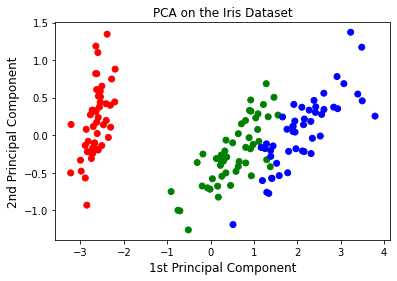

In [20]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], color=df_iris['Color'].values)

plt.title("PCA on the Iris Dataset", fontsize=12)
plt.xlabel('1st Principal Component', fontsize=12)
plt.ylabel('2nd Principal Component', fontsize=12)

plt.show()

In [21]:
colours

{'Iris-setosa': 'r', 'Iris-versicolor': 'g', 'Iris-virginica': 'b'}

- What can we observe about the clusters above?

## Visual Assessment for Clustering Tendency (VAT) 
- Treat it as a black box (so it's moreso about interpretation rather than method).
- You need to understand how VAT works, but not how to implement it by code.
- Good to see how many clusters exist in a dataset *without* having to plot everything at once (to find values of $k$). 
- **Note:** Doesn't do well when the "clusters" are not distinct (i.e overlap in the data or some complex relationship).

Pseudocode:
1. Compute the dissimilarity matrix `D` (that is, an $n\times n$ matrix of pairwise distances).
2. Let $K = \{1, ..., n\}$ be the set of unique values in `D`.
3. From `D`, pick the two most contrasting values $a, b$ (i.e two furthest points using `max()` and `min()`).
4. Let the initial sets now be $I = \{a\}$ and $J = K - \{a\}$. That is, $I$ is a set with only point $a$, and $J$ is the set with every other point except $a$. 
5. Assign the 1st Permutation $P(1)$ to be the initial point $a$ (the first point in our new VAT matrix `D*`).
6. Then, for $r$ in $\{2, ..., n\}$ (for the initial $n$ elements, we now have $n-1$ remaining in $J$):
    1. From `D`, pick the two most similar points $i,j$ (i.e the two closest points)
    1. (BUT!) $i$ must come from the set $I$, and $j$ must come from the set $J$. (Initially, this will just be $i=a$ and $j$ will be any point in $J$)
    1. Add $j$ to the set $I$ and remove $j$ from $J$. In set notation: $I = I\cup\{j\}$ and $J = J-\{j\}$.
    1. Finally, assign the current permutation $P(r) = j$ for the new VAT matrix `D*`.
7. Once you have computed all of `D*` (thew new VAT matrix), you now have the new permutation required!


In [24]:
import math, random
import seaborn as sns

from scipy.spatial.distance import pdist, squareform

# local script
from vat import VAT

## Heatmaps vs VAT
We'll plot the three visualisations:
1. Heatmap
2. Dissimilarity Matrix
3. VAT

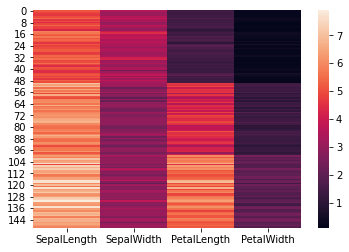

In [27]:
# heatmap
sns.heatmap(X)

plt.show()

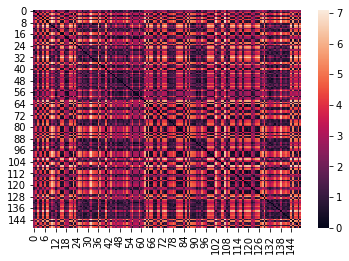

In [34]:
# dissimilarity matrix
dmatrix = X.copy().values
np.random.shuffle(dmatrix)

dm = squareform(pdist(dmatrix))
sns.heatmap(dm)

plt.show()

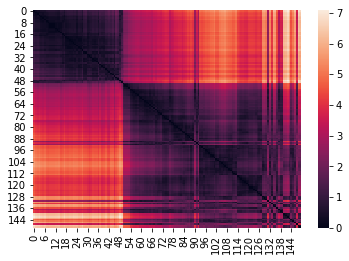

In [36]:
# VAT
RV, C, I = VAT(dmatrix)

sns.heatmap(RV)

plt.show()

## Questions
Compare the VAT visualisation with PCA.
- How do the two differ?
- What clusters are easily shown?